In [1]:
![ -f tinyshakespear.txt ] || curl -L -o tinyshakespear.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [2]:
import torch as th
import numpy as np

In [3]:
import re
from gensim.models import Word2Vec

with open('tinyshakespear.txt', 'r') as f:
    corpus = f.read()

PADDING_TOKEN = '<pad>'
UNKOWN_TOKEN = '<unk>'
sentences  = []
START_OF_SENTENCE = "<sos>"
END_OF_SENTENCE = "<eos>"

sentence_sizes = []
for sentence in corpus.strip().lower().split('.'):
    sent =  re.findall(r"[a-z]+", sentence)
    if len(sent) == 0:
        continue

    sentence_sizes.append(len(sent))
        
    sentences.append(
        [START_OF_SENTENCE] + sent +  [END_OF_SENTENCE]
    )

embedding_dim = 50
word_embeddings = Word2Vec(
    # just including the extra tokens
    sentences + [[PADDING_TOKEN, PADDING_TOKEN, UNKOWN_TOKEN]],
    vector_size=embedding_dim,
    window=5,
    min_count=1,
    workers=4,
    sg=1
)

vocabulary = {word: i for i, word in enumerate(word_embeddings.wv.index_to_key)}
reverse_index = {i: x for x, i in vocabulary.items()}

PADDING_ID = vocabulary[PADDING_TOKEN]
UNKOWN_ID = vocabulary[UNKOWN_TOKEN]

def encode_sentence(sentence: list[str]):
    return [vocabulary.get(word, UNKOWN_ID) for word in sentence]

encoded_sentences = [encode_sentence(sentence) for sentence in sentences]

def decode_sentence(sentence: list[int]):
    return [reverse_index[x] for x in sentence]

print("Vocab size:", len(vocabulary))
print("Total sentences:", len(sentences))
min_size, max_size = min(sentence_sizes), max(sentence_sizes)
mean, std = np.mean(sentence_sizes), np.std(sentence_sizes)
median = np.median(sentence_sizes)
print(f"Sentence distribution: min:{min_size} 50%:{median} max:{max_size} (mean:{mean}; std:{std})") 

Vocab size: 11459
Total sentences: 7885
Sentence distribution: min:1 50%:19.0 max:259 (mean:26.4429930247305; std:23.505672288255084)


# Simple LSTM Model

In [4]:
class SimpleLSTM(th.nn.Module):
    def __init__(self, input_embedd_dim: int, hidden_dim: int, vocab: dict[str,int] , word_embeddings: Word2Vec | None = None, freeze_embedding_weight = True):
        super().__init__()
        vocab_size = len(vocab)
        if word_embeddings == None:
            self.embeddings = th.nn.Embedding(vocab_size, input_embedd_dim)
        else:
            # https://docs.pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding.from_pretrained
            embedding_matrix = th.zeros(vocab_size, input_embedd_dim)
            for word, idx in vocab.items():
                embedding_matrix[idx] = th.tensor(word_embeddings.wv[word])
                
            self.embeddings = th.nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze_embedding_weight)
            
        self.lstm = th.nn.LSTM(
            input_size=input_embedd_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        self.fc = th.nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x: th.Tensor, hidden=None):
        # x: (batch, seq_len)
        inp = self.embeddings(x)
        out, hidden = self.lstm(inp, hidden)
        # out: (batch, seq_len, hidden_size)
        logits = self.fc(out)
        # logits: (batch, seq_len, vocab_size
        return logits, hidden

In [5]:
import random
def batch_generator(sentences: list[list[int]], seq_len: int, batch_size: int,
                    padding_id: int = PADDING_ID, shuffle: bool = True, min_size: int = 2):
    
    if shuffle:
        sentences = sentences.copy()
        random.shuffle(sentences)

    batch_inputs = []
    batch_targets = []

    for sentence in sentences:
        for i in range(0, len(sentence), seq_len):
            chunk = sentence[i : i+seq_len+1]
            if len(chunk) < min_size:
                continue 
                
            inp = chunk[:-1]
            tgt = chunk[1:]
            # P(token_{i+1} | token_i), so the training data has input batch
            # the target is the window shifted onestep to the right
            if len(inp) < seq_len:
                pad_amt = seq_len - len(inp)
                inp += [padding_id]*pad_amt
                tgt += [padding_id]*pad_amt
                
            batch_inputs.append(inp)
            batch_targets.append(tgt)

            if len(batch_inputs) == batch_size:
                yield (
                    th.tensor(batch_inputs),
                    th.tensor(batch_targets),
                )
                batch_inputs, batch_targets = [], []
                
    if batch_inputs:
        yield (
            th.tensor(batch_inputs),
            th.tensor(batch_targets),
        )
        
for inpt, target in batch_generator(encoded_sentences,seq_len=5, batch_size=3, shuffle=False):
    print("Input data:")
    for x in inpt:
        print(x, decode_sentence(x.tolist()))
    print("Target data:")
    for y in target:
        print(y, decode_sentence(y.tolist()))
    break

Input data:
tensor([  1,  94, 279, 146,  34]) ['<sos>', 'first', 'citizen', 'before', 'we']
tensor([1020,  152,  685,  132,   18]) ['proceed', 'any', 'further', 'hear', 'me']
tensor([ 109, 4793, 4793, 4793, 4793]) ['speak', '<pad>', '<pad>', '<pad>', '<pad>']
Target data:
tensor([  94,  279,  146,   34, 1020]) ['first', 'citizen', 'before', 'we', 'proceed']
tensor([152, 685, 132,  18, 109]) ['any', 'further', 'hear', 'me', 'speak']
tensor([   0, 4793, 4793, 4793, 4793]) ['<eos>', '<pad>', '<pad>', '<pad>', '<pad>']


In [6]:
seq_len = 10
batch_size = 512
epochs = 10
log_batch = 10 # every n batch log the loss
eta = 0.001
hidden_dim = 128

sentence_yapper = SimpleLSTM(input_embedd_dim=embedding_dim, hidden_dim=hidden_dim, vocab=vocabulary, 
                             word_embeddings=word_embeddings, freeze_embedding_weight=False)
criterion = th.nn.CrossEntropyLoss(ignore_index=PADDING_ID)
optimizer = th.optim.Adam(sentence_yapper.parameters(), lr=eta)

losses = []
vocab_size = len(vocabulary)
for i in range(epochs):
    print(f"Epoch #{i+1}...")
    for i, (inputs, targets) in enumerate(batch_generator(encoded_sentences, seq_len=seq_len, 
                                           batch_size=batch_size, shuffle=True)):
        optimizer.zero_grad()
        logits, _ = sentence_yapper(inputs)
    
        loss = criterion(
            logits.view(-1, vocab_size),
            targets.view(-1)
        )
    
        loss.backward()
        optimizer.step()
        loss_val = loss.item()
        losses.append(loss_val)
        if (i % log_batch) == 0:
            print(f"Batch #{i+1}: loss: {loss_val:.5f}")
    print(f"Batch #{i+1}: epoch final loss: {loss_val:.5f}")      

Epoch #1...
Batch #1: loss: 9.34742
Batch #11: loss: 9.11539
Batch #21: loss: 7.91238
Batch #31: loss: 7.04782
Batch #41: loss: 7.07113
Batch #50: epoch final loss: 7.08274
Epoch #2...
Batch #1: loss: 6.79100
Batch #11: loss: 6.72126
Batch #21: loss: 6.77726
Batch #31: loss: 6.85706
Batch #41: loss: 6.82983
Batch #50: epoch final loss: 6.52888
Epoch #3...
Batch #1: loss: 6.60010
Batch #11: loss: 6.75264
Batch #21: loss: 6.67591
Batch #31: loss: 6.67317
Batch #41: loss: 6.65370
Batch #50: epoch final loss: 6.35594
Epoch #4...
Batch #1: loss: 6.55236
Batch #11: loss: 6.55322
Batch #21: loss: 6.70755
Batch #31: loss: 6.58825
Batch #41: loss: 6.57665
Batch #50: epoch final loss: 6.46633
Epoch #5...
Batch #1: loss: 6.59361
Batch #11: loss: 6.59898
Batch #21: loss: 6.53141
Batch #31: loss: 6.45179
Batch #41: loss: 6.52172
Batch #50: epoch final loss: 6.85664
Epoch #6...
Batch #1: loss: 6.54521
Batch #11: loss: 6.51459
Batch #21: loss: 6.53099
Batch #31: loss: 6.50491
Batch #41: loss: 6.39739

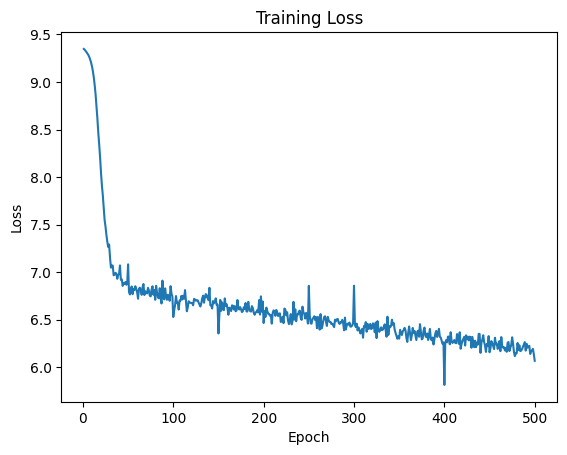

In [7]:
import matplotlib.pyplot as plt

updates = list(range(1, len(losses)+1))
plt.figure()
plt.plot(updates, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [8]:
def sample_sentence(model, seed_sentence: str, max_len: int =100, greedy=False, generations = 5):

    start_words = seed_sentence.split(' ')
    
    seed_sequence = [vocabulary[START_OF_SENTENCE]]
    for word in start_words:
        seed_sequence.append(vocabulary.get(word, UNKOWN_ID))
        
  
    seed_sentence = [START_OF_SENTENCE]
    for word in start_words:
        seed_sentence.append(word)
    
    if greedy and generations > 1:
        generations = 1

    all_generated_sentences = []
    
    for i in range(1, generations+1):
        sequence = seed_sequence.copy()
        input_ids = th.tensor(sequence, dtype=th.long).unsqueeze(0)
        hidden = None
        
        print(f"{i})",end ="")
        for word in seed_sentence:
            print(word, end=" ")

        with th.no_grad():
            for _ in range(max_len):
                logits, hidden = model(input_ids, hidden)
                next_logits = logits[:, -1, :]
    
                if greedy:
                    next_id = next_logits.argmax(dim=-1)
                else:
                    probs = th.softmax(next_logits, dim=-1)
                    next_id = th.multinomial(probs, 1).squeeze(1)
    
                input_ids = next_id.unsqueeze(1)
                sequence.append(next_id.item())
                word = reverse_index[sequence[-1]] 
                print(word, end= " ") 
                if word == END_OF_SENTENCE:
                    break
        print()      
        all_generated_sentences.append(sequence)
        
    return all_generated_sentences

In [9]:
yap = sample_sentence(sentence_yapper, seed_sentence="the woman and man",greedy=False)

1)<sos> the woman and man me not a our palace of yours d heaven go warwick nay very sweet mete elizabeth am no brazen floods be suns himself call it in eyed sun o look shall the power <eos> 
2)<sos> the woman and man request some at hour king here elizabeth it peepeth he cambio starve my the counsel <eos> 
3)<sos> the woman and man than skill to so made call the face early shall i him a higher great letters remains and when have arms to kings him will and the banishment england the queen richard will if isabella were sport alas us have proclaim you were chastisement your forgot <eos> 
4)<sos> the woman and man presently at when i france what i desirest in his deformity how adieu my shepherd love <eos> 
5)<sos> the woman and man thyself <eos> 


# Seq2Seq 

In [10]:
import torch as th
class Seq2Seq(th.nn.Module):
    def __init__(self, input_embedd_dim: int, hidden_dim: int, vocab_size: int):
        super().__init__()

        # same embeddings for source and target
        self.embeddings = th.nn.Embedding(vocab_size, input_embedd_dim)
            
        self.encoder = th.nn.LSTM(
            input_size=input_embedd_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        self.decoder = th.nn.LSTM(
            input_size=input_embedd_dim, 
            hidden_size=hidden_dim,
            batch_first = True
        )

        self.fc = th.nn.Linear(hidden_dim, vocab_size)

    def encode(self, x: th.Tensor):
        """Encoder block compress the sentence to single vector"""
        inp = self.embeddings(x)
        return self.encoder(inp)[1]

    def decode(self, y: th.Tensor, hidden: tuple[th.Tensor, th.Tensor]):
        """Decoder block is an autoregressive generator"""
        tgt = self.embeddings(y)
        out, hidden_states = self.decoder(tgt, hidden)
        logits = self.fc(out)
        return logits, hidden_states
        
    def forward(self, x: th.Tensor, y: th.Tensor):
        encoded_states = self.encode(x)
        logits, _ = self.decode(y, encoded_states)
        return logits

In [12]:
import random
from torch.nn.utils.rnn import pad_sequence

def generate_simple_expressions(batch_size: int, n_variable: int,
                                expr_range: tuple[int, int], number_range: tuple[float, float], float_round: int = 2):

    assert expr_range[0] >= 1
    variable_names = 'abcdefghijklmnopqrstuvwxyz'
    ops = '+-/*'

    start_of_answer = '['
    end_of_answer = ']'
    start_of_express = '$'
    end_of_express = '!'
    nan_repr = '#'

    def get_numbered_variables():
        _vars = set(random.choices(variable_names, k=n_variable))
        _mi,_mx = number_range
        _delta = _mx - _mi

        numbers = np.random.random(len(_vars))
        numbers = _mi + _delta*numbers
        
        return {x: round(numbers[i], float_round) for i, x in enumerate(_vars)}

    def build_expression(variables, operations, var_num_map):
        _source_stack = []
        _open_parans = 0
        
        for i in range(len(variables) - 1):
            op = operations[i]
            va = variables[i]

            # randomly add paran
            opened_now = False
            if random.random() > (0.5 ** (_open_parans +1)):
                _source_stack.append('(')
                _open_parans += 1
                opened_now = True
            
            _source_stack.append(va)
            
            # close parans
            if not opened_now and _open_parans > 0 and random.random() > 0.5:
                    _source_stack.append(')')
                    _open_parans -= 1
            
            _source_stack.append(op)
            
            
        _source_stack.append(variables[-1])
        if _open_parans > 0:
            for _ in range(_open_parans):
                _source_stack.append(')')
            
        _expr_for_eval = ' '.join([x if (x in '+/-*()') else str(var_num_map[x]) for x in _source_stack])
        
        source_expression = start_of_express + ' '.join(_source_stack) + '; '+ ', '.join([f'{v}={n}' for v,n in var_num_map.items()]) + end_of_express 
        try:
            trgt = str(round(eval(_expr_for_eval),float_round))
        except ZeroDivisionError:
            trgt = nan_repr
            
        target_value = start_of_answer + trgt + end_of_answer
        return source_expression, target_value
        
    expressions = []
    targets = []
    for i in range(batch_size):
        _vars = get_numbered_variables()
        _unque_vars = len(_vars)
        _expr_range = random.randint(max(_unque_vars, expr_range[0]), expr_range[1])
        _exp_symbols = random.choices(ops,k= _expr_range - 1)

        _varkeys = list(_vars.keys())
        if _expr_range > _unque_vars:
            repeated_vars = random.choices(_varkeys, k=_expr_range - _unque_vars)
            _varkeys += repeated_vars
            
        random.shuffle(_varkeys)
        expression, target = build_expression(_varkeys, _exp_symbols, _vars)
        expressions.append(expression)
        targets.append(target)
    return expressions, targets

PADDING_TOKEN = '|'
UNKNOWN_CHAR = '?'
reverse_index = PADDING_TOKEN + 'abcdefghijklmnopqrstuvwxyz' +  '+-/*()=' + '[]$!#;, ' + '.0123456789' + UNKNOWN_CHAR
PADDING_TOKEN_ID = 0
vocabulary = {x:i for i, x in enumerate(reverse_index)}
UNKNOWN_CHAR_ID = vocabulary[UNKNOWN_CHAR]
vocab_size = len(vocabulary)

def encode_expression(exp: str):
    return [vocabulary.get(x, UNKNOWN_CHAR_ID) for x in exp]

def decode_expression(exp: list[int]):
    return [reverse_index[x] for x in exp]
    
def collate(batch):
    """
    add right padding, returns Tensor [B, T]
    """
    return pad_sequence(
        [th.tensor(x, dtype=th.long) for x in batch],
        batch_first=True,
        padding_value=PADDING_TOKEN_ID
    )
print("Vocabulary size", vocab_size)
exprs, trgts = generate_simple_expressions(2, 3, (1,5), (-10, 10))
print(exprs)
print(trgts)

enc = encode_expression(exprs[0])
print(enc)
dec = decode_expression(enc)
print(dec)
assert ''.join(dec) == exprs[0]
print(collate([encode_expression(x) for x in exprs]))

Vocabulary size 54
['$( l + ( x + ( u / ( u * l ) ) ) ); l=1.89, x=-9.99, u=9.37!', '$j * f * l - j; l=-3.3, f=5.14, j=3.61!']
['[-7.57]', '[-64.84]']
[36, 31, 41, 12, 41, 27, 41, 31, 41, 24, 41, 27, 41, 31, 41, 21, 41, 29, 41, 31, 41, 21, 41, 30, 41, 12, 41, 32, 41, 32, 41, 32, 41, 32, 39, 41, 12, 33, 44, 42, 51, 52, 40, 41, 24, 33, 28, 52, 42, 52, 52, 40, 41, 21, 33, 52, 42, 46, 50, 37]
['$', '(', ' ', 'l', ' ', '+', ' ', '(', ' ', 'x', ' ', '+', ' ', '(', ' ', 'u', ' ', '/', ' ', '(', ' ', 'u', ' ', '*', ' ', 'l', ' ', ')', ' ', ')', ' ', ')', ' ', ')', ';', ' ', 'l', '=', '1', '.', '8', '9', ',', ' ', 'x', '=', '-', '9', '.', '9', '9', ',', ' ', 'u', '=', '9', '.', '3', '7', '!']
tensor([[36, 31, 41, 12, 41, 27, 41, 31, 41, 24, 41, 27, 41, 31, 41, 21, 41, 29,
         41, 31, 41, 21, 41, 30, 41, 12, 41, 32, 41, 32, 41, 32, 41, 32, 39, 41,
         12, 33, 44, 42, 51, 52, 40, 41, 24, 33, 28, 52, 42, 52, 52, 40, 41, 21,
         33, 52, 42, 46, 50, 37],
        [36, 10, 41, 30, 41,  

In [13]:
eta = 0.001
embedding_dim = 64
hidden_dim = 512

batch_size = 256
n_vars = 3
expr_range = (2, 5)
number_range = (-10, 10)
float_round = 2

epochs = 10
batches_per_epoch = 32

calc = Seq2Seq(
    input_embedd_dim=embedding_dim,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size
)
criterion = th.nn.CrossEntropyLoss(ignore_index=PADDING_TOKEN_ID)
optimizer = th.optim.Adam(calc.parameters(), lr=eta)

losses = []
for epoch in range(epochs):
    for i in range(batches_per_epoch):
    
        src_batch, tgt_batch = generate_simple_expressions(batch_size, n_vars, expr_range, number_range, float_round)
        src = collate([encode_expression(x) for x in src_batch])
        tgt = collate([encode_expression(x) for x in tgt_batch])

        # teacher forcing again but only for target not src
        tgt_input = tgt[:, :-1]  
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()

        logits = calc(src, tgt_input)
        
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            tgt_output.reshape(-1)
        )

        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        losses.append(loss_val)

        print(f"Epoch {epoch+1} Batch {i+1}: loss = {loss_val:.4f}")

Epoch 1 Batch 1: loss = 3.9930
Epoch 1 Batch 2: loss = 3.8647
Epoch 1 Batch 3: loss = 3.6905
Epoch 1 Batch 4: loss = 3.3661
Epoch 1 Batch 5: loss = 2.8545
Epoch 1 Batch 6: loss = 2.5116
Epoch 1 Batch 7: loss = 2.2776
Epoch 1 Batch 8: loss = 2.1727
Epoch 1 Batch 9: loss = 2.1249
Epoch 1 Batch 10: loss = 2.0598
Epoch 1 Batch 11: loss = 2.0207
Epoch 1 Batch 12: loss = 1.9902
Epoch 1 Batch 13: loss = 1.9778
Epoch 1 Batch 14: loss = 1.9859
Epoch 1 Batch 15: loss = 1.9629
Epoch 1 Batch 16: loss = 1.9588
Epoch 1 Batch 17: loss = 1.9378
Epoch 1 Batch 18: loss = 1.9104
Epoch 1 Batch 19: loss = 1.8760
Epoch 1 Batch 20: loss = 1.8572
Epoch 1 Batch 21: loss = 1.8473
Epoch 1 Batch 22: loss = 1.8268
Epoch 1 Batch 23: loss = 1.8401
Epoch 1 Batch 24: loss = 1.8044
Epoch 1 Batch 25: loss = 1.7834
Epoch 1 Batch 26: loss = 1.7673
Epoch 1 Batch 27: loss = 1.7913
Epoch 1 Batch 28: loss = 1.7657
Epoch 1 Batch 29: loss = 1.7751
Epoch 1 Batch 30: loss = 1.7345
Epoch 1 Batch 31: loss = 1.7380
Epoch 1 Batch 32:

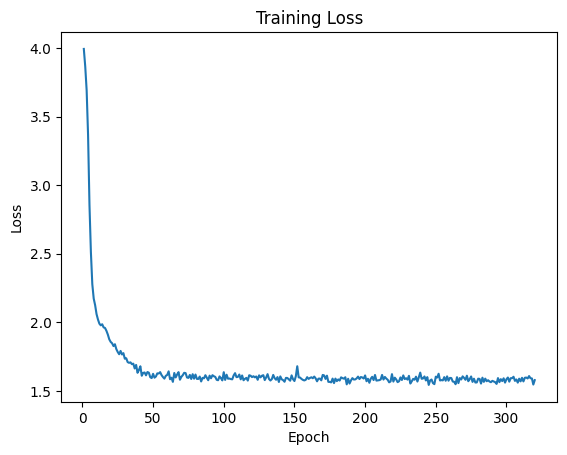

In [14]:
import matplotlib.pyplot as plt

updates = list(range(1, len(losses)+1))
plt.figure()
plt.plot(updates, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [15]:
def sample(
    calc,
    expr:str,
    max_len: int = 10,
    greedy: bool = True,
):

    expr = [encode_expression(expr)]

    with th.no_grad():
        hidden = calc.encode(collate(expr))

    
        y = th.full(
            (1, 1),
            vocabulary['['],
            dtype=th.long,
            device=src.device
        )

        outputs = [vocabulary['[']]
    
        for _ in range(max_len):
            logits, hidden = calc.decode(y[:, -1:], hidden)
            # logits: [B, 1, vocab]
            logits = logits.squeeze(1)
    
            if greedy:
                next_token = logits.argmax(dim=-1)
            else:
                probs = th.softmax(logits, dim=-1)
                next_token = th.multinomial(probs, num_samples=1).squeeze(1)
    
            outputs.append(next_token.item())
    
            y = th.cat([y, next_token.unsqueeze(1)], dim=1)
    
            # early stop if all finished
            if (next_token == vocabulary[']']).all():
                break
    
    return outputs

In [23]:
for source, tgt in zip(*generate_simple_expressions(5, n_vars, expr_range, number_range, float_round)):
    result = sample(calc, source, greedy=True)
    predict = ''.join(decode_expression(result))
    print(f"{source} = {tgt}\nCalc = {predict}")

$r - v * ( d + v ); d=0.57, v=-0.91, r=3.05! = [2.74]
Calc = [-1.0]
$p + ( g + z ); g=6.66, z=-7.07, p=8.5! = [8.09]
Calc = [-1.0]
$( r * ( p - ( p / j ) / r ) ); j=6.1, p=-7.37, r=1.71! = [-11.39]
Calc = [-1.0]
$m * h * x + ( m + m ); h=-8.65, m=-9.82, x=-4.92! = [-437.56]
Calc = [-0.0]
$( e * ( b * q ) ); b=-7.46, q=-3.7, e=-5.61! = [-154.85]
Calc = [-1.0]
